# Numba
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numba
print("Numba:", numba.__version__)

Numba: 0.40.0


# Mandelbrot fractal

In [2]:
def mandelbrot(m, size, iterations):    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0 / size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z * z + c
                    m[i, j] = n
                else:
                    break

In [3]:
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)

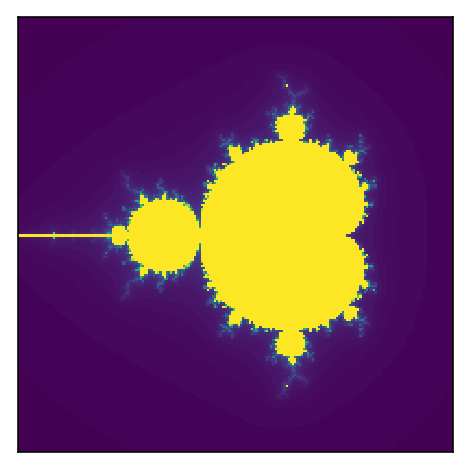

In [4]:
mandelbrot(m, size, iterations)
plt.imshow(m, cmap='viridis')
plt.xticks([])
plt.yticks([]);

# Numba

[Numba](http://numba.pydata.org) speeds functions written directly in Python. 
With a few annotations, array-oriented and math-heavy Python code can be *just-in-time* (JIT) compiled to native machine instructions, similar in performance to C, C++ and Fortran, without having to switch languages or Python interpreters.

Roughly, [JIT](https://en.wikipedia.org/wiki/Just-in-time_compilation) compilation combines the speed of compiled code with the flexibility of interpretation, with the overhead of an interpreter and the additional overhead of compiling (not just interpreting).

Numba also allows to release the GIL, thus allowing multithreading in CPU-bounded applications; it also allows to automatically parallelize code - see details in a [blog post](https://www.anaconda.com/blog/developer-blog/parallel-python-with-numba-and-parallelaccelerator/) by Anaconda.

In [5]:
numandelbrot = numba.jit(mandelbrot)
numandelbrot(m, size, iterations); # run once for jit to work

In [6]:
size = 200
iterations = 200
m = np.zeros((size, size), dtype=np.int32)

%time mandelbrot(m, size, iterations)
%time numandelbrot(m, size, iterations)

CPU times: user 2.64 s, sys: 8.75 ms, total: 2.65 s
Wall time: 2.66 s
CPU times: user 9.19 ms, sys: 182 µs, total: 9.37 ms
Wall time: 9.29 ms


# Exercise:

Consider the following NumPy function which calculates the mean squared error of two arrays/

In [7]:
def mean_squared_error_np(yhat, y):
    return ((yhat - y)**2).mean()

Write a pure-Python version of this function, then JIT it with Numba.

To JIT a function you can use `@numba.jit` as a decorator rather than define the function and then pass it to `numba.jit(...)`; for example:

```py
@numba.jit
def foo(x):
    pass
```

In [8]:
def mean_squared_error_py(yhat, y):
    pass

def mean_squared_error_nm(yhat, y):
    pass

In [9]:
n = 100000
y = np.random.random(n)
yhat = np.random.random(n)
%timeit mean_squared_error_np(yhat, y)
%timeit mean_squared_error_py(yhat, y)
%timeit mean_squared_error_nm(yhat, y)

138 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
109 ns ± 14.5 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
109 ns ± 11 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


# Releasing the GIL

Numba can be used to release the GIL, thus enabling multiple threads to run in parallel (if the OS allows it) and achieve performence gain even in comparison to multi-processing, as threads are cheaper than processes and thread communication is faster than process communication.

In [37]:
def display_image(im):
    plt.imshow(im, cmap='gray')
    plt.xticks([])
    plt.yticks([])

In [38]:
%pwd

'/Users/yoavram/Work/Teaching/SciComPy/notebooks'

Let's do a segmentation demonstration.

(dtype('float64'), (900, 944), 0.0, 255.0)

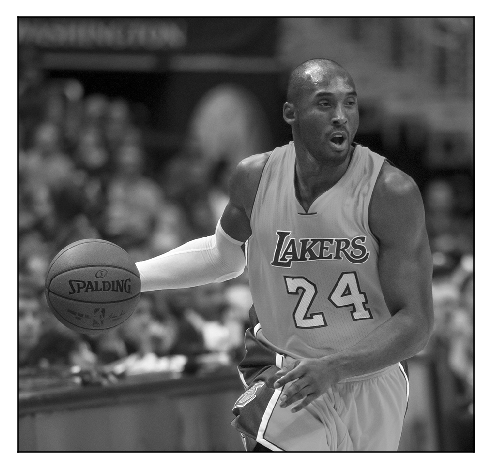

In [39]:
# original image from https://upload.wikimedia.org/wikipedia/commons/5/56/Kobe_Bryant_2014.jpg
import imageio
image = imageio.imread('../data/Kobe_Bryant_2014.jpg')
image = image.mean(axis=2) # greyscale
display_image(image)
image.dtype, image.shape, image.min(), image.max()

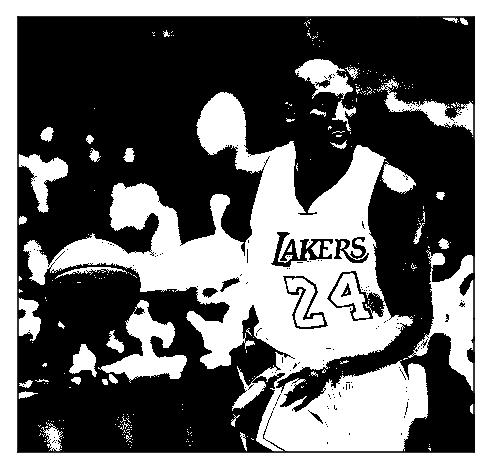

In [40]:
def segment(image, threshold):
    output = np.zeros_like(image)
    output[image > threshold] = 255
    return output

display_image(segment(image, 100))

In [41]:
nsegment = numba.jit(segment)
nsegment(image, 100);

In [42]:
%timeit _ = segment(image, 100)
%timeit _ = nsegment(image, 100)

2.81 ms ± 303 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.14 ms ± 459 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So performance on a single image is similar, what about using multi-threading for segmenting a bunch of images?

Let's download the 30 examples images from the [PASCAL VOC 2012 dataset](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html).

![example](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/05.jpg)

In [43]:
image_urls = [
    'http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/images/{:02d}.jpg'.format(i)
    for i in range(1,31)
]

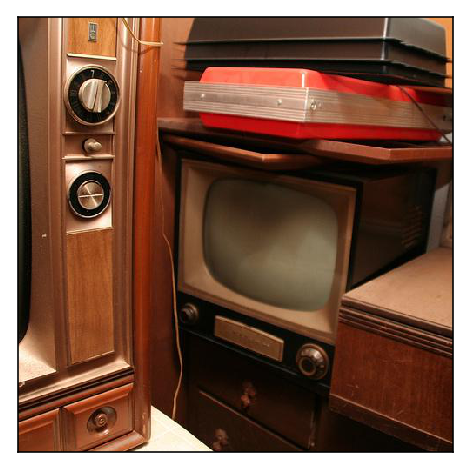

In [44]:
display_image(imageio.imread(image_urls[4]))

Let's load and flatten the images:

In [45]:
images = [imageio.imread(url) for url in image_urls]
images = [im.mean(axis=2) for im in images]

Let's also resize the images so that the segmentation task is harder.

In [46]:
from skimage.transform import resize

In [47]:
shapes = [im.shape for im in images]
images = [resize(im, (w*12, h*12), mode='reflect') 
          for im, (w, h) in zip(images, shapes)]

/Users/yoavram/miniconda3/envs/SciComPy/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


First compare the NumPy and Numba versions:

In [48]:
%time _ = [segment(im, 100) for im in images]
%time _ = [nsegment(im, 100) for im in images]

CPU times: user 3.69 s, sys: 7.21 s, total: 10.9 s
Wall time: 16.8 s
CPU times: user 4.02 s, sys: 8.51 s, total: 12.5 s
Wall time: 17.6 s


No real difference, of course.
Now let's do it with multi-threading, leveraging the `nogil` directive.

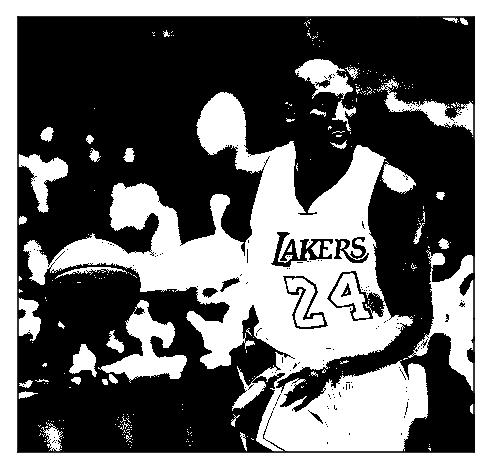

In [49]:
@numba.jit(nopython=True, nogil=True)
def _nmsegment(image, threshold, output):
    n, m = image.shape
    for i in range(n):
        for j in range(m):
            if image[i, j] > threshold:
                output[i, j] = 255
            else:
                output[i, j] = 0
    return output

def nmsegment(image, threshold):
    output = np.empty_like(image)
    _nmsegment(image, threshold, output)
    return output

display_image(nmsegment(image, 100))

In [50]:
%time _ = segment(images[0], 100)
%time _ = nmsegment(images[0], 100);

CPU times: user 154 ms, sys: 801 ms, total: 954 ms
Wall time: 938 ms
CPU times: user 68.5 ms, sys: 83.6 ms, total: 152 ms
Wall time: 152 ms


In [51]:
from concurrent.futures import ThreadPoolExecutor

def segment_parallel(images, threshold):  
    def func(image):
            return nmsegment(image, threshold)
    
    with ThreadPoolExecutor() as executor:        
        results = executor.map(func, images)
        return list(results)

In [52]:
%time _ = [nmsegment(im, 100) for im in images]
%time _ = segment_parallel(images, 100);

CPU times: user 2.07 s, sys: 2.67 s, total: 4.74 s
Wall time: 5.24 s
CPU times: user 3.29 s, sys: 7.16 s, total: 10.5 s
Wall time: 6.35 s


# Numba automatic parallelization

Numba uses Intel's MKL to automate parallelization of for loops with multiple threads.

Consider the function for calculation of MSE:

In [53]:
@numba.jit
def mean_squared_error_nm(yhat, y):
    mse = 0
    n = len(y)
    for i in range(n):
        mse += (yhat[i] - y[i])**2
    mse /= n
    return mse

We can parallelize it by adding the `parallel=True` directive (which requires that we can set `nopython=True` without getting an error) and using `numba.prange` instead of `range`:

In [54]:
@numba.jit(parallel=True, nopython=True)
def mean_squared_error_pr(yhat, y):
    mse = 0
    n = len(y)
    for i in numba.prange(n):
        mse += (yhat[i] - y[i])**2
    mse /= n
    return mse

In [55]:
n = 1000000
y = np.random.random(n)
yhat = np.random.random(n)
%time _ = mean_squared_error_nm(yhat, y)
%time _ = mean_squared_error_pr(yhat, y);

CPU times: user 64.2 ms, sys: 523 ms, total: 588 ms
Wall time: 605 ms
CPU times: user 246 ms, sys: 23.3 ms, total: 269 ms
Wall time: 292 ms


Roughly two-fold faster - which makes sense on my 2-CPU machine.

# Numba stencils (local filters)

Numba's `stencil` decorator works similar to SciPy's `generic_filter`, but uses the JIT capabilities of Numba.

Let's start by adding some noise to the images:

In [56]:
def salt_pepper(image, p=0.01):
    """Generates salt and pepper noise.
    
    Each pixel is "hit" independently with probability `p`. 
    If hit, a pixel has 1:1 chance of becoming white or black.
    """
    noisy = image.copy()
    rand = np.random.random(size=noisy.shape)
    mask_black = rand <= p/2
    noisy[mask_black] = 0
    mask_white = (p/2 < rand) & (rand <= p)
    noisy[mask_white] = 255
    return noisy

In [57]:
noisy = [salt_pepper(im, p=0.25) for im in images]

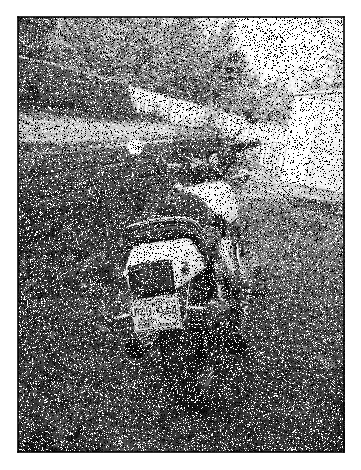

In [58]:
display_image(noisy[1])

Now let's clean the images with a bounded mean filter.

We write a function that accepts a 2D neighborhood, the dimensions of which can be specified in the `stencil` directive, and return the stencil (i.e. local filter) result.
The `stencil` decorator does the rest.

In [59]:
k = 5
white_th=250
black_th=5

def local_bounded_mean(image, black_th, white_th, kernel_size):
    k = kernel_size
    
    @numba.stencil(neighborhood=((-k, k), (-k, k)))
    def stencil(neighbours):
        center_pixel = neighbours[0,0]
        if center_pixel < black_th or center_pixel > white_th:
            acc, cnt = 0, 0
            for i in range(-k, k+1):
                for j in range(-k, k+1):
                    pixel = neighbours[i,j]
                    if pixel >= black_th and pixel <= white_th:
                        acc += pixel
                        cnt += 1
            if cnt > 0:
                return acc / cnt
        return center_pixel
    
    return stencil(image)

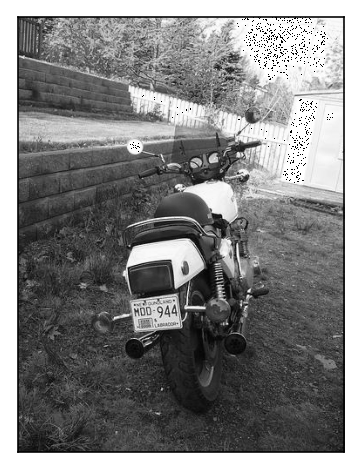

In [60]:
display_image(local_bounded_mean(noisy[1], 5, 250, k))

Compare this with the SciPy version:

In [61]:
from scipy.ndimage import generic_filter

def local_bounded_mean2(image, black_th, white_th, kernel_size):
    n = 2*kernel_size+1
    def stencil(neighbours):
        center = neighbours.size // 2
        center_pixel = neighbours[center]
        if center_pixel < black_th or center_pixel > white_th:
            mask = (black_th <= neighbours) & (neighbours <= white_th)
            if mask.any():
                return neighbours[mask].mean()
        # either center was not extreme or all its neighbors are extreme
        return center_pixel

    return generic_filter(image, stencil, size=(n, n))

In [62]:
%time _ = local_bounded_mean(noisy[0], 5, 250, k)
%time _ = local_bounded_mean2(noisy[0], 5, 250, k);

CPU times: user 2.86 s, sys: 225 ms, total: 3.09 s
Wall time: 3.11 s
CPU times: user 2min, sys: 420 ms, total: 2min 1s
Wall time: 2min 1s


# References

- [IPython Cookbook](https://ipython-books.github.io/cookbook/) by Cyrille Rossant has a full chapter on high performance computing. with many [notebook examples](https://github.com/ipython-books/cookbook-code/tree/master/notebooks/chapter05_hpc) and a more complicated Cython example.
- [Numba](http://numba.pydata.org/)
- [Parallelization with Numba](https://www.anaconda.com/blog/developer-blog/parallel-python-with-numba-and-parallelaccelerator/)
- [Numexpr](https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide)
- [Blaze Ecosystem](http://blaze.pydata.org/)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.6.1.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)